# Project 2 - Coronavirus

This project consist to estimate the SIR model with data from WHO.

In [2]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [3]:
import PDEparams as pde

## Estimacion de parametros.
Tomaremos los datos de Brazil en la siguente liga https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases?force_layout=desktop, usaremos el modelo de SIR y estimaremos los parametros por medio de los datos.

### Definiendo e modelo.

S: Suceptibles, son las personas que podrian tener la enfermedad.

I: Infectados, personas con la enfermedad.

R: Recuperados, personas que tuvieron la enfermedad y ahora se han recuperado.

El modelo esta formado por las siguetes ecuaciones

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$


Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

In [133]:
df = pd.read_csv('BrazilCovid2.csv')

df

,Confirmados,Recuperados
0,3058,10980
1,2105,0
2,3257,0
3,2976,0
4,1996,8104
...,...,...
90,41857,32174
91,39924,26673
92,45403,47433
93,34177,30989


In [134]:
N = 209500000 #poblacion total de brasil

data = {'Tiempo' : range(0,len(df)) ,
        'Infectados' : df.Confirmados }
        #'Recuperados' : df.Recuperados }

df = pd.DataFrame(data)

df

,Tiempo,Infectados
0,0,3058
1,1,2105
2,2,3257
3,3,2976
4,4,1996
...,...,...
90,90,41857
91,91,39924
92,92,45403
93,93,34177


In [135]:
def BrazilCovid(z, t, b, g):
    '''The input z corresponds to the current state of the system, z = [S, I, R]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    a and b correspond to the unknown parameters.
    '''
    
    S, I, R = z
    
    return [-b*S*I /N, b*S*I /N-g*I,  g*I]

### Condiciones iniciales

In [136]:
def initial_S():  #suceptibles
    return N-3058-10980

def initial_I():  #infectados
    return 3058

def initial_R():  #recuperados
    return 10980

In [137]:
my_model = pde.PDEmodel(df, BrazilCovid, [initial_S, initial_I, initial_R], bounds=[(0, 5), (0,5)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

## Aproximando los parametros

In [138]:
%%time
my_model.fit()

        $b$       $g$
0  2.567925  2.521214
Wall time: 1.57 s


In [139]:
my_model.best_params

,$b$,$g$
0,2.567925,2.521214


In [140]:
my_model.best_error

45683978.38656186

In [141]:
%%time
my_model.likelihood_profiles()



Wall time: 3min 9s


In [142]:
my_model.result_profiles

,parameter,value,error
0,$b$,0.000000,5.433791e+08
1,$b$,0.050505,1.025297e+08
2,$b$,0.101010,6.592062e+08
3,$b$,0.151515,1.023028e+08
4,$b$,0.202020,1.021042e+08
...,...,...,...
195,$g$,4.797980,3.142430e+08
196,$g$,4.848485,3.206657e+08
197,$g$,4.898990,3.269468e+08
198,$g$,4.949495,6.572415e+08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


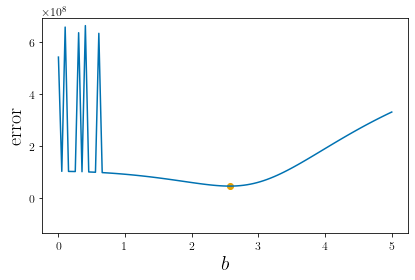

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


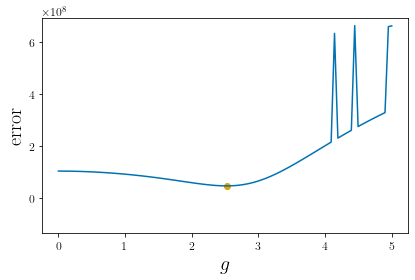

In [143]:
my_model.plot_profiles()

## Comparacion datos reales y el modelo


In [144]:
# Tomamos los valores del modelo
beta = my_model.best_params.iloc[0,0]
gamma = my_model.best_params.iloc[0,1]

In [145]:
#Condiciones indiciales
I_0 = 3058
R_0 = 10980
S_0= N - I_0 - R_0
z_0 = S_0, I_0, R_0
t = np.linspace(0, len(df), len(df))

In [146]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(BrazilCovid, z_0, t, args=(beta, gamma))
S, I, R = ret.T

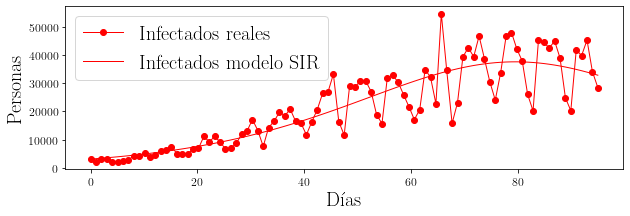

In [147]:
fig = plt.figure(figsize=(10,3))
plt.plot(t, df.Infectados, '-ok', color='r', label='Infectados reales', lw = 1)
plt.plot(t, I, color = 'r', label='Infectados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.legend()
plt.show()

## Modelo con recuperados.

In [148]:
df = pd.read_csv('BrazilCovid2.csv')

df

,Confirmados,Recuperados
0,3058,10980
1,2105,0
2,3257,0
3,2976,0
4,1996,8104
...,...,...
90,41857,32174
91,39924,26673
92,45403,47433
93,34177,30989


In [149]:
data = {'Tiempo' : range(0,len(df)) ,
        #'Infectados' : df.Confirmados,
        'Recuperados' : df.Recuperados }

df = pd.DataFrame(data)

df

,Tiempo,Recuperados
0,0,10980
1,1,0
2,2,0
3,3,0
4,4,8104
...,...,...
90,90,32174
91,91,26673
92,92,47433
93,93,30989


In [150]:
my_model = pde.PDEmodel(df, BrazilCovid, [initial_S, initial_I, initial_R], bounds=[(0, 5), (0,5)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [151]:
%%time
my_model.fit()

        $b$       $g$
0  0.048786  0.010243
Wall time: 1.69 s


In [152]:
my_model.best_params

,$b$,$g$
0,0.048786,0.010243


In [153]:
my_model.best_error

269568820.36718774

In [154]:
%%time
my_model.likelihood_profiles()



Wall time: 1min 58s


In [155]:
my_model.result_profiles

,parameter,value,error
0,$b$,0.000000,3.606891e+08
1,$b$,0.050505,2.698590e+08
2,$b$,0.101010,3.293588e+08
3,$b$,0.151515,3.568265e+08
4,$b$,0.202020,3.652950e+08
...,...,...,...
195,$g$,4.797980,3.699829e+08
196,$g$,4.848485,3.699863e+08
197,$g$,4.898990,3.699864e+08
198,$g$,4.949495,3.699880e+08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


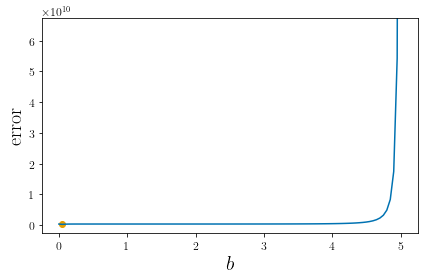

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


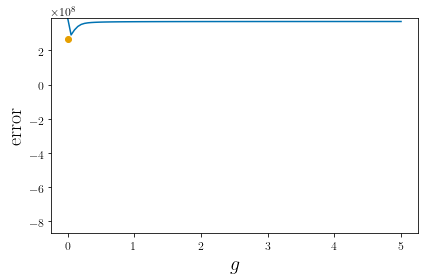

In [156]:
my_model.plot_profiles()

In [157]:
# Tomamos los valores del modelo
beta = my_model.best_params.iloc[0,0]
gamma = my_model.best_params.iloc[0,1]

In [158]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(BrazilCovid, z_0, t, args=(beta, gamma))
S, I, R = ret.T

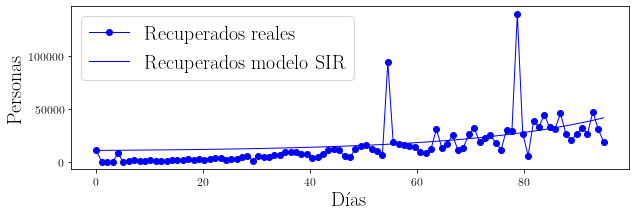

In [160]:
fig = plt.figure(figsize=(10,3))
plt.plot(t, df.Recuperados, '-ok', color='b', label='Recuperados reales', lw = 1)
plt.plot(t, R, color = 'b', label='Recuperados modelo SIR', lw = 1)
plt.xlabel('Días')
plt.ylabel('Personas')
plt.legend()
plt.show()

## Conclusiones

Debido a que en la tabla my_model.result_profiles, los valores de $\beta$ y $\gamma$ para la variable de infectados es $\beta=2.567925$ y $\gamma=2.521214$ y respecto a los recuperados $\beta=0.048786$ y $\gamma=0.010243$. Los valores estan mejor identificados en el modelo respecto a los infectados como se puede ver en las graficas de identificabiliad.